In [47]:
%matplotlib inline
from cca_zoo.models import CCA
from cca_zoo.data import generate_covariance_data
from cca_zoo.models import rCCA
from cca_zoo.model_selection import GridSearchCV
from cca_zoo.deepmodels import architectures
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [29]:
(train_view_1,train_view_2),(true_weights_1,true_weights_2)=generate_covariance_data(n=200,view_features=[10,10],latent_dims=100,correlation=1)

In [5]:
train_view_1

array([[-0.89491483, -0.57796163,  0.20014337, ...,  1.41891266,
        -0.29555641, -0.89333418],
       [ 0.71199708,  0.6393824 , -1.11738447, ...,  0.08858433,
        -1.24379199, -0.57202807],
       [ 1.5413662 ,  0.0466759 , -2.33054911, ..., -0.65676295,
         0.15218453, -0.75706414],
       ...,
       [-0.9426455 ,  0.11079315,  1.01173001, ..., -0.24629306,
         0.75936387,  0.74540425],
       [ 1.08133476, -0.67241988, -0.06655327, ...,  0.59339799,
        -0.66014785,  2.79088646],
       [ 0.13841383,  2.17626391,  1.42869877, ...,  0.70035798,
        -1.43062602, -0.3973502 ]])

In [73]:
latent_dims=9
linear_cca = CCA(latent_dims=latent_dims)

In [74]:
linear_cca.fit([train_view_1, train_view_2])

CCA(latent_dims=9, random_state=RandomState(MT19937) at 0x2A5FF3F7A40)

In [75]:
z1, z2 = linear_cca.fit_transform([train_view_1, train_view_2])

In [14]:
len(z2)

200

In [38]:
correlation=linear_cca.score([train_view_1,train_view_2])
correlation

array([0.99981618, 0.59947104, 0.39032647, 0.36108709, 0.27487408,
       0.2225249 , 0.14434168, 0.1045679 , 0.08189783])

In [52]:
dims = [i for i in range(1,9+1)]
dims
cor_df = pd.DataFrame(list(zip(dims,correlation)),\
                      columns=['latent_dim','cor']) 
cor_df.head()

,latent_dim,cor
0,1,0.999816
1,2,0.599471
2,3,0.390326
3,4,0.361087
4,5,0.274874


In [84]:
cor =[ i+0.325 for i in correlation]
cor_test = pd.DataFrame(list(zip(dims,cor)),\
                      columns=['latent_dim','cor']) 

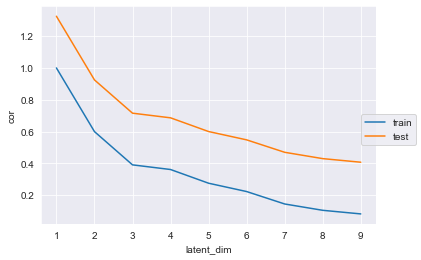

In [99]:
fig, ax = plt.subplots()
sns.set_style('darkgrid')
dfs = [cor_df,cor_test]
for df in dfs:
    sns.lineplot(data = df, x='latent_dim',y='cor',ax=ax)
fig.legend(labels=['train', 'test'], loc='center right')
plt.show()


In [26]:
w1 = linear_cca.weights[0]
w1

array([[ 0.18477549, -0.03592807, -0.51215859],
       [ 0.4518874 ,  0.06769055,  0.06002952],
       [-0.26721969,  0.04612326, -0.453014  ],
       [ 0.23649633, -0.59274112,  0.06896725],
       [-0.42060384,  0.11289602,  0.32773964],
       [ 0.21630463,  0.54196795, -0.41918049],
       [-0.41333183, -0.02906376,  0.31138391],
       [-0.2248347 ,  0.27995507, -0.00065995],
       [-0.48095482, -0.44467074, -0.57450483],
       [ 0.06831883, -0.43514932,  0.04049554]])